In [ ]:
#Importo e instalo las librerías necesarias para la tarea

!pip install eurostat
import eurostat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen

Luego, ingreso al generador de queries de Eurostat para generar el dataset filtrado necesario. Aplico los criterios especificados en la tarea.

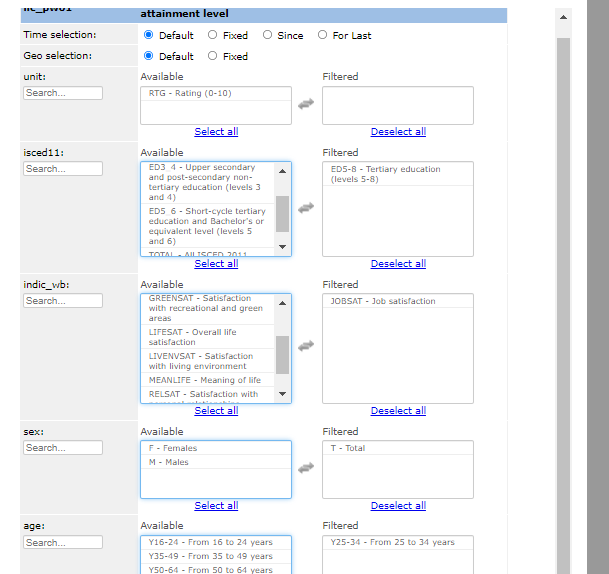

Una vez aplicados los filtros, se genera la parte dinámica de la API request. Concateno la parte dinámica generada con la estática (url de eurostat, versión de la API, formato de descarga, idioma, etc.). Finalmente hago una llamada con json.load() para obtener el json de la query por medio del llamado a la API.

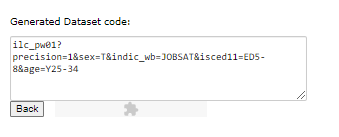

In [ ]:
url_query = "http://ec.europa.eu/eurostat/wdds/rest/data/v2.1/json/en/ilc_pw01?precision=1&sex=T&indic_wb=JOBSAT&isced11=ED5-8&age=Y25-34 "

consulta_eurostat = json.load(urlopen(url_query))


Con .keys obtengo todas las llaves del diccionario (a nivel primario, ya que por ejemplo, la llave dimension tiene "sub diccionarios" con distintas llaves por si misma).

In [ ]:
consulta_eurostat.keys()

dict_keys(['version', 'label', 'href', 'source', 'updated', 'status', 'extension', 'class', 'value', 'dimension', 'id', 'size'])

In [ ]:
consulta_eurostat["dimension"]

{'age': {'category': {'index': {'Y25-34': 0},
   'label': {'Y25-34': 'From 25 to 34 years'}},
  'label': 'age'},
 'geo': {'category': {'index': {'AL': 0,
    'AT': 1,
    'BE': 2,
    'BG': 3,
    'CH': 4,
    'CY': 5,
    'CZ': 6,
    'DE': 7,
    'DK': 8,
    'EA': 9,
    'EA18': 10,
    'EA19': 11,
    'EE': 12,
    'EL': 13,
    'ES': 14,
    'EU': 15,
    'EU27_2007': 16,
    'EU27_2020': 17,
    'EU28': 18,
    'FI': 19,
    'FR': 20,
    'HR': 21,
    'HU': 22,
    'IE': 23,
    'IS': 24,
    'IT': 25,
    'LT': 26,
    'LU': 27,
    'LV': 28,
    'ME': 29,
    'MK': 30,
    'MT': 31,
    'NL': 32,
    'NO': 33,
    'PL': 34,
    'PT': 35,
    'RO': 36,
    'RS': 37,
    'SE': 38,
    'SI': 39,
    'SK': 40,
    'TR': 41,
    'UK': 42,
    'XK': 43},
   'label': {'AL': 'Albania',
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CH': 'Switzerland',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DE': 'Germany (until 1990 former territory of the FRG)',
    'DK': 

En la llave dimension, se ve que hay una subdivisión que mapea sigla del país con el nombre completo del mismo. Esto será utilizado posteriormente para tener el nombre completo del país al generar la gráfica y facilitar el entendimiento de la misma.

In [ ]:
eurostat_lib_df = eurostat.get_data_df("ilc_pw01")

Por medio del paso anterior, estoy utilizando la librería para python de eurostat. Como ya sabemos el nombre del dataset requerido, directamente hago un .get_data_df para obtener el dataset en formato Pandas Dataframe. Posteriormente, en la celda debajo, aplico los filtros requeridos para obtener el mismo dataframe que en la API request y muestro una cabecera de 6 filas del dataset generado.

In [ ]:
eurostat_filtered= pd.DataFrame(eurostat_lib_df.loc[
                                      (eurostat_lib_df["isced11"] == "ED5-8") &
                                      (eurostat_lib_df["indic_wb"] == "JOBSAT") &
                                      (eurostat_lib_df["sex"] == "T")&
                                      (eurostat_lib_df["age"] == "Y25-34")
                                      ])

eurostat_filtered.head(6)

,unit,isced11,indic_wb,sex,age,geo\time,2018,2013
23641,RTG,ED5-8,JOBSAT,T,Y25-34,AL,6.5,NaN
23642,RTG,ED5-8,JOBSAT,T,Y25-34,AT,8.0,8.1
23643,RTG,ED5-8,JOBSAT,T,Y25-34,BE,7.6,7.4
23644,RTG,ED5-8,JOBSAT,T,Y25-34,BG,7.0,6.9
23645,RTG,ED5-8,JOBSAT,T,Y25-34,CH,7.5,NaN
23646,RTG,ED5-8,JOBSAT,T,Y25-34,CY,7.4,7.4


Descripción de las variables del dataset:

unit = Variable categórica nominal

isced11 = Variable categórica ordinal; se ordena por nivel de estudios.

indic_wb = Variable categórica nominal: es el tipo de indicador que se está tomando.

sex = Variable categórica nominal.

age = Variable categórica ordinal. Las categórias de edad se pueden ordenar.

2018 y 2013 = Variables cuantitativas continuas.

In [ ]:
diccionario_paises = consulta_eurostat["dimension"]["geo"]["category"]["label"]
eurostat_filtered["Country full name"] = eurostat_filtered[r"geo\time"].map(diccionario_paises)
eurostat_filtered.sort_values(by= 2018, ascending= True, inplace=True)


En el paso anterior, hice un mapeo del diccionario "label" contenido en "category"+"geo"+"dimension" visto anteriormente. Lo que hace este mapeo es buscar la sigla del país existente en la columna "geo\time" del dataframe eurostat_filtered como llave del diccionario y devuelve el valor relacionado a cada una en una nueva columna del df.

Como último paso, ordeno la información por la columna 2018 (que es la que tiene la tasa de satisfacción del año objeto de estudio).

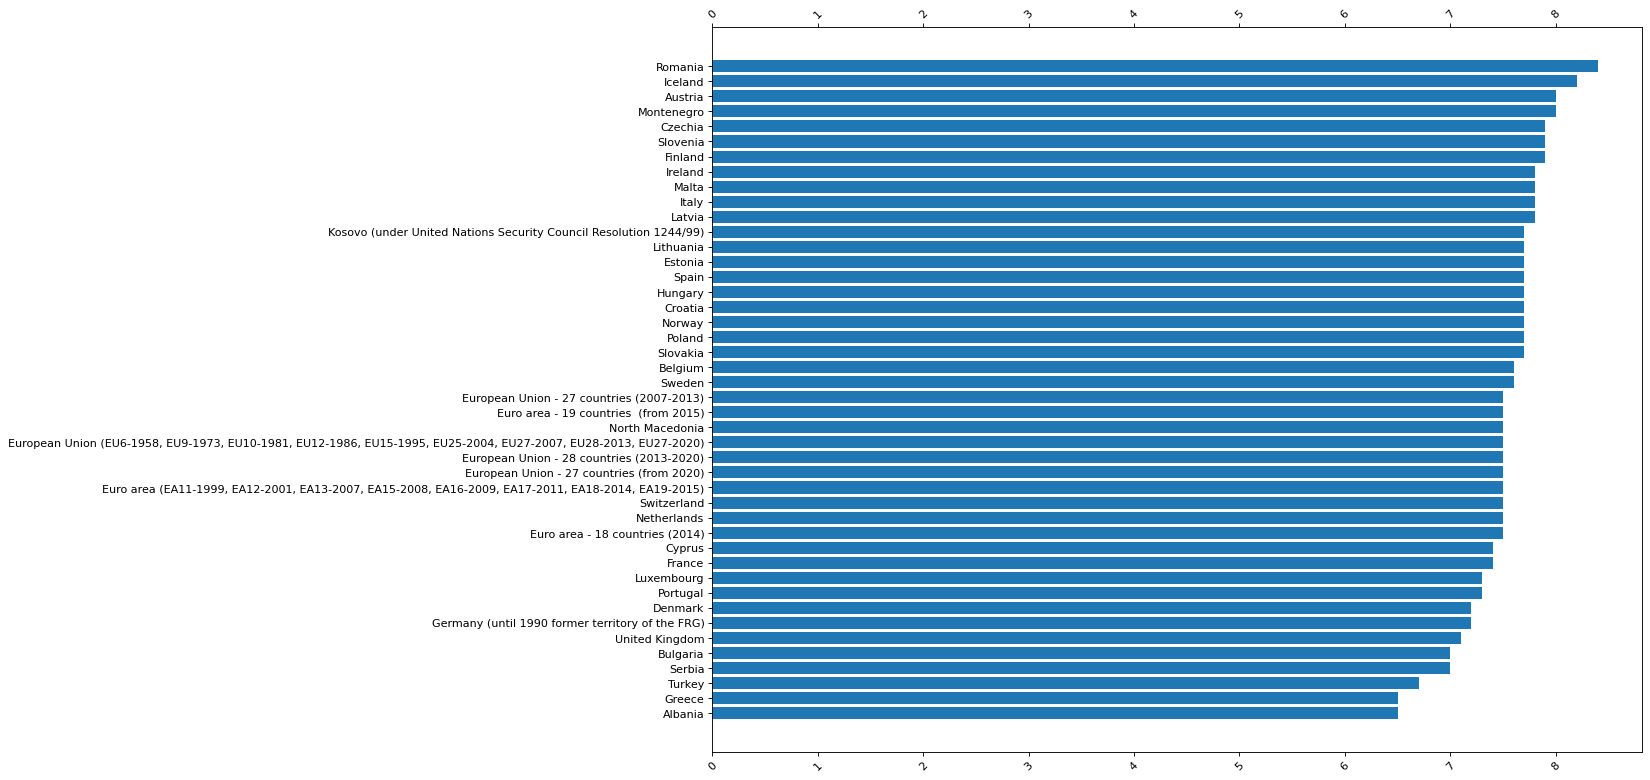

In [ ]:
plt.figure(figsize=(15,12), dpi= 80)
plt.barh(eurostat_filtered["Country full name"], eurostat_filtered[2018])
#Agrego eje de X tanto arriba como abajo para facilitar lectura
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xticks(rotation=45)
plt.show()

El gráfico superior contiene algunos campos que no son relevantes al estudio (ej.: Euro area -18 countries (2014)). 

Dado lo anterior, procedo a eliminarlos del dataframe para posteriormente generar un nuevo gráfico.

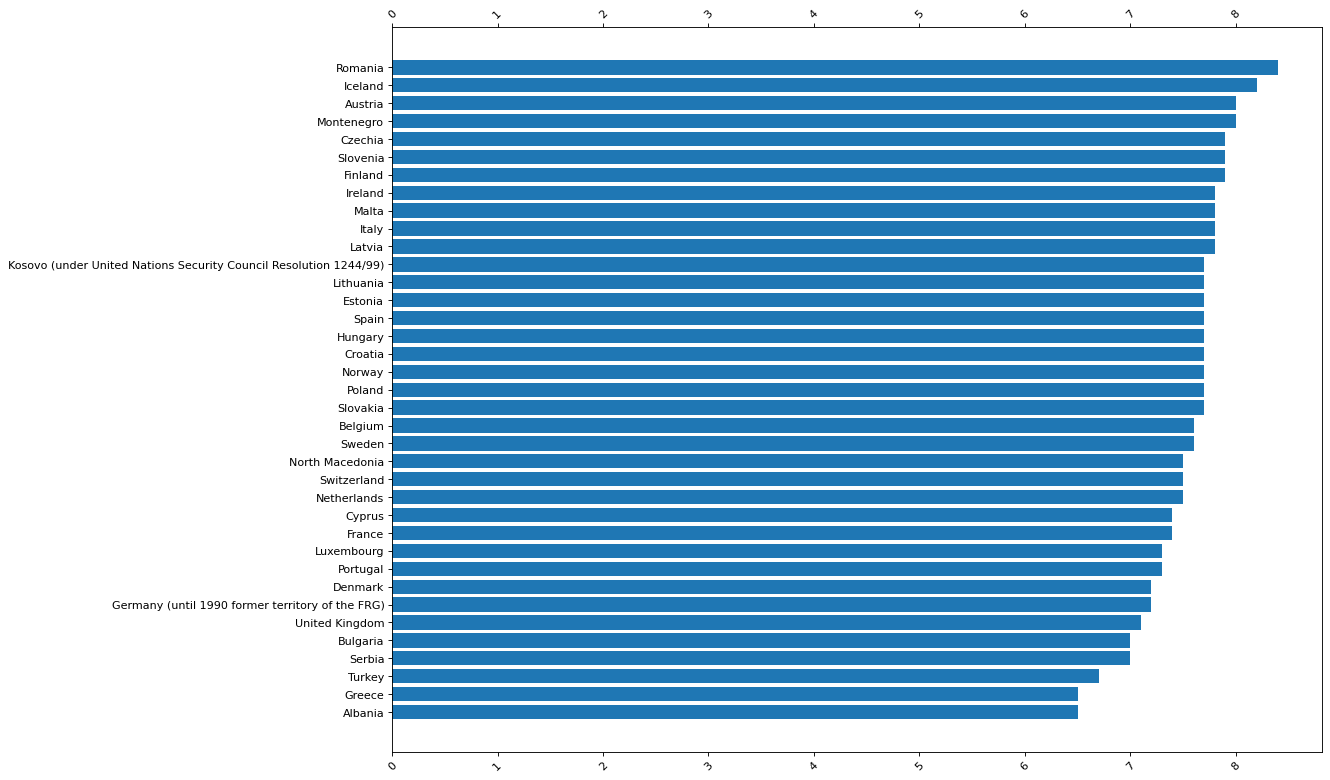

In [ ]:
#Elimino/modifico nombres de países para que se haga mas simple la lectura del gráfico

eurostat_filtered = eurostat_filtered.drop(eurostat_filtered[eurostat_filtered["Country full name"].str.contains("Euro")].index)
plt.figure(figsize=(15,12), dpi= 80)
plt.barh(eurostat_filtered["Country full name"], eurostat_filtered[2018])
#Agrego eje de X tanto arriba como abajo para facilitar lectura
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.xticks(rotation=45)
plt.show()

A partir del dataset anterior, que se puede ver representado gráficamente en la celda superior, se puede concluir que el país que tiene mayor grado de satisfacción laboral entre la población de 15 a 24 años con estudios terciarios es Rumania (tasa= 8.4).

Por otro lado, el último puesto de este ranking lo comparten Grecia y Albania con una tasa de 6.5.